# 08/01/2024
Fiona Zheng

In [339]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi
import seaborn as sns
import os
import datetime
from datetime import datetime
import holidays
import matplotlib.dates as mdates
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import warnings
warnings.filterwarnings('ignore')

In [778]:
df_19 = pd.read_excel(r'data/DM 2019 hourly load.xlsx')
df_2122 = pd.read_excel(r'data/Hourly DM Invoice load 21-22.xlsx')
df_2124 = pd.read_csv(r'data/load_scada_actual.csv')

In [311]:
df_19 = df_19[['Period', 'all']]
df_19['all'] = df_19['all']/1000
df_19 = df_19.rename(columns = {'all': 'gross_load', 'Period': 'hour begins'})

# Function to replace '24:00' with '00:00' of the next day
def replace_24_hour_format(date_str):
    if '24:00' in date_str:
        date_str = date_str.replace('24:00', '00:00')
        date = pd.to_datetime(date_str, format='%m/%d/%Y %H:%M') + pd.Timedelta(days=1)
    else:
        date = pd.to_datetime(date_str, format='%m/%d/%Y %I:%M %p')
    return date

# Apply the replacement function
df_19['hour begins'] = df_19['hour begins'].apply(replace_24_hour_format)
# acsending order of the date

In [312]:
df_19

,hour begins,gross_load
0,2019-01-01 01:00:00,82.496
1,2019-01-01 02:00:00,80.378
2,2019-01-01 03:00:00,79.438
3,2019-01-01 04:00:00,79.360
4,2019-01-01 05:00:00,82.306
...,...,...
8731,2019-12-30 20:00:00,93.743
8732,2019-12-30 21:00:00,92.213
8733,2019-12-30 22:00:00,88.253
8734,2019-12-30 23:00:00,84.077


In [313]:
df_2122 = df_2122[['HOUR BEGINS', 'TOTAL METERED LOAD with LOSSES (MWs)']]
df_2122 = df_2122.rename(columns = {'HOUR BEGINS': 'hour begins', 'TOTAL METERED LOAD with LOSSES (MWs)': 'gross_load'})
# ascending order of the date
df_2122 = df_2122.sort_values(by='hour begins')

In [314]:
df_2122

,hour begins,gross_load
3648,2021-06-01 00:00:00,33.0630
3649,2021-06-01 01:00:00,31.5690
3650,2021-06-01 02:00:00,30.7650
3651,2021-06-01 03:00:00,30.3080
3652,2021-06-01 04:00:00,31.5240
...,...,...
3643,2022-05-31 19:00:00,54.9494
3644,2022-05-31 20:00:00,55.8330
3645,2022-05-31 21:00:00,55.3010
3646,2022-05-31 22:00:00,50.0280


In [315]:
# df_2124
df_2124.drop(columns=['lmp', 'tag_actual', 'tag_scheduled', 'netload', 'netload_source', 'date_local', 'he_local', 'tz',
                 'lastest_update_utc'], inplace=True)
df_2124 = df_2124[df_2124['load_name'] == 'DMEA']
df_2124.drop(columns=['load_name'], inplace=True)
df_2124.rename(columns={'timestamp': 'hour begins'}, inplace=True)

# turn 2024-07-30 19:00:00+00:00 into 2024-07-30 19:00:00
df_2124['hour begins'] = df_2124['hour begins'].apply(lambda x: x.split('+')[0])
df_2124['hour begins'] = pd.to_datetime(df_2124['hour begins'])
df_2124.sort_values(by='hour begins', inplace=True)

In [316]:
df_2124

,hour begins,gross_load
109752,2021-10-21 18:00:00,58.728000
118748,2021-10-21 19:00:00,62.769083
127745,2021-10-21 20:00:00,62.078933
136749,2021-10-21 21:00:00,63.153767
145759,2021-10-21 22:00:00,65.232000
...,...,...
59,2024-07-31 07:00:00,55.465217
60,2024-07-31 08:00:00,54.373650
61,2024-07-31 09:00:00,50.037567
62,2024-07-31 10:00:00,51.308583


In [317]:
# there is overlap of the date in df_2124 and df_2122
# drop the overlap date in df_2124
df_2124 = df_2124[~df_2124['hour begins'].isin(df_2122['hour begins'])]
# merge the dataframes
df = pd.concat([df_19, df_2122, df_2124], axis=0)
df = df.sort_values(by='hour begins')
df.reset_index(drop=True, inplace=True)


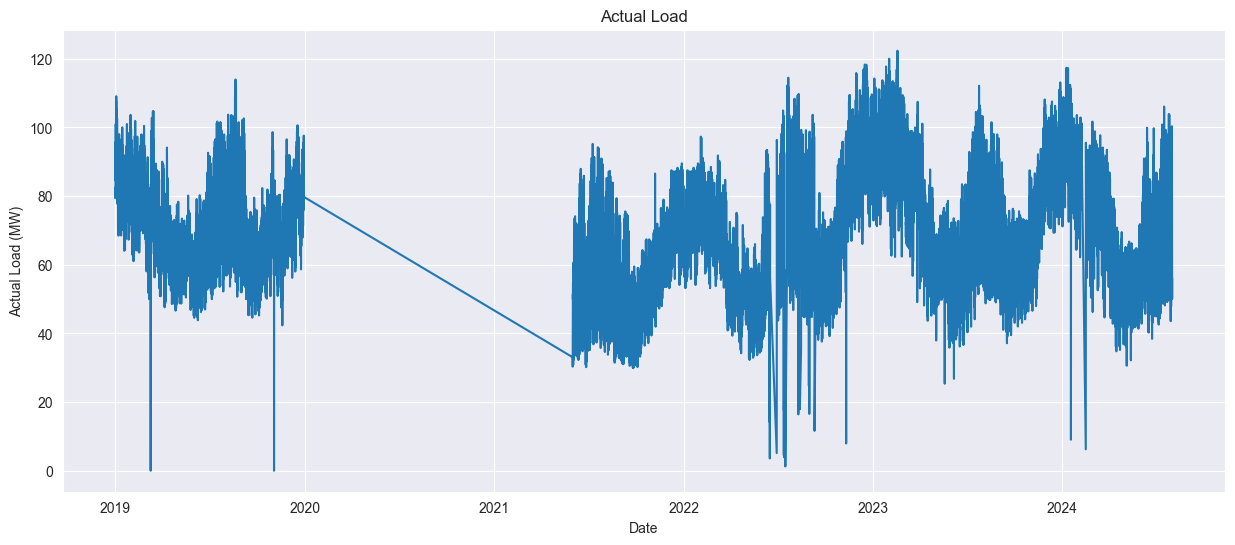

In [318]:
# plot 
plt.figure(figsize=(15, 6))
plt.plot(df['hour begins'], df['gross_load'])
plt.title('Actual Load')
plt.xlabel('Date')
plt.ylabel('Actual Load (MW)')
plt.show()

Number of outliers: 714


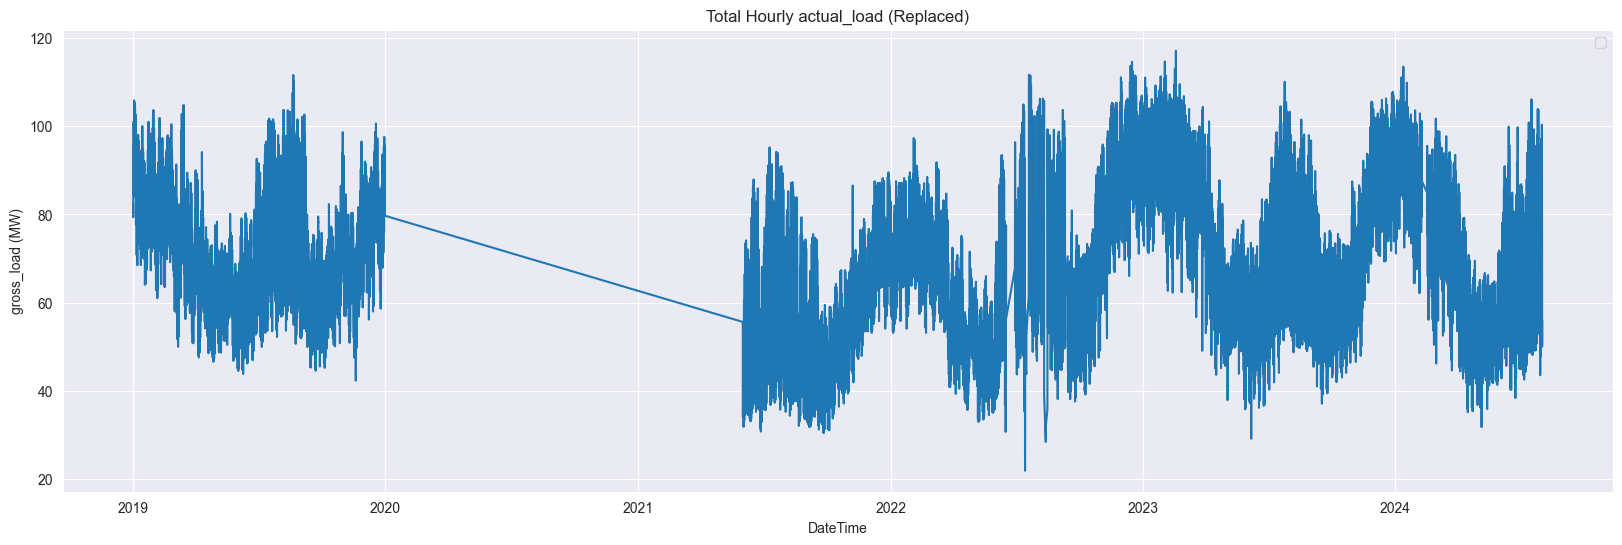

In [319]:
# replace the outlier values as the average of the previous day and the next day
def replace_outliers_with_avg(s):
    lower_bound = s.quantile(0.01)
    upper_bound = s.quantile(0.99)
    outliers = (s < lower_bound) | (s > upper_bound)
    
    for idx in s[outliers].index:
        if idx == 0 or idx == len(s) - 1:
            # directly drop the first and last value
            s.at[idx] = np.nan
            continue
        prev_val = s.iloc[idx - 1]
        next_val = s.iloc[idx + 1]
        s.at[idx] = (prev_val + next_val) / 2
    return s

# reset index 
df.reset_index(drop=True, inplace=True)
# Assuming df is your DataFrame and 'timestamp' and 'gross_load' are the relevant columns
df['gross_load_replaced'] = replace_outliers_with_avg(df['gross_load'].copy())

# Number of outliers
print(f'Number of outliers: {df[df["gross_load"] != df["gross_load_replaced"]].shape[0]}')

# Plot the replaced 'gross_load_replaced'
plt.figure(figsize=(20, 6))
plt.plot(df['hour begins'], df['gross_load_replaced'])
plt.xlabel('DateTime')
plt.ylabel('gross_load (MW)')
plt.title('Total Hourly actual_load (Replaced)')
plt.legend()
plt.show()

In [320]:
df

,hour begins,gross_load,gross_load_replaced
0,2019-01-01 01:00:00,82.496000,82.496000
1,2019-01-01 02:00:00,80.378000,80.378000
2,2019-01-01 03:00:00,79.438000,79.438000
3,2019-01-01 04:00:00,79.360000,79.360000
4,2019-01-01 05:00:00,82.306000,82.306000
...,...,...,...
35659,2024-07-31 07:00:00,55.465217,55.465217
35660,2024-07-31 08:00:00,54.373650,54.373650
35661,2024-07-31 09:00:00,50.037567,50.037567
35662,2024-07-31 10:00:00,51.308583,51.308583


In [756]:
# calculate the daily average load
df['date'] = df['hour begins'].dt.date
daily_gross_load = df.groupby('date')['gross_load_replaced'].mean().reset_index()
daily_high = df.groupby('date')['gross_load_replaced'].max().reset_index()
daily_low = df.groupby('date')['gross_load_replaced'].min().reset_index()
daily_std = df.groupby('date')['gross_load_replaced'].std().reset_index()

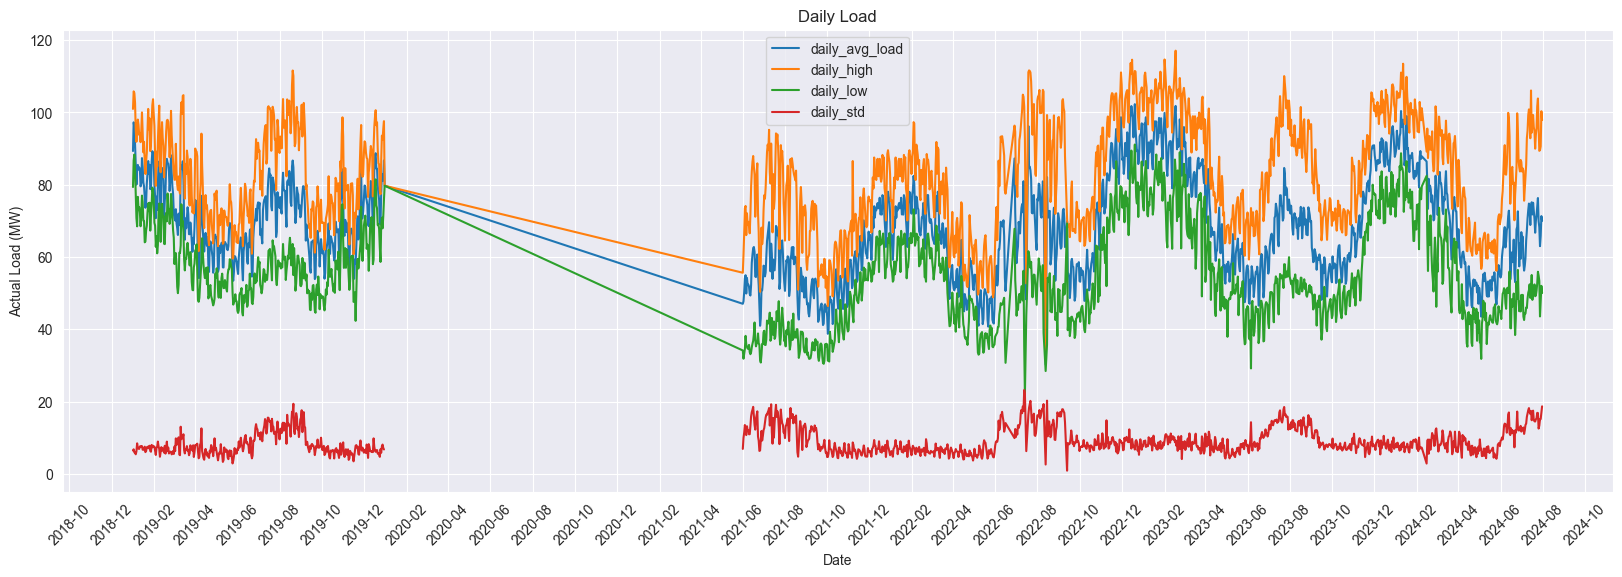

In [757]:
daily_gross_load['daily_high'] = daily_high['gross_load_replaced']
daily_gross_load['daily_low'] = daily_low['gross_load_replaced']
daily_gross_load['daily_std'] = daily_std['gross_load_replaced']

# plot the daily average, min, max, std
plt.figure(figsize=(20, 6))
plt.plot(daily_gross_load['date'], daily_gross_load['gross_load_replaced'], label='daily_avg_load')
plt.plot(daily_gross_load['date'], daily_gross_load['daily_high'], label='daily_high')
plt.plot(daily_gross_load['date'], daily_gross_load['daily_low'], label='daily_low')
plt.plot(daily_gross_load['date'], daily_gross_load['daily_std'], label='daily_std')
plt.xlabel('Date')
plt.ylabel('Actual Load (MW)')
plt.title('Daily Load')
plt.legend()

# Set date format on x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # set to show every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.show()

In [758]:
# day of the week, month, year, season vairables
daily_gross_load['date'] = pd.to_datetime(daily_gross_load['date'])
daily_gross_load['day_of_week'] = daily_gross_load['date'].dt.dayofweek
daily_gross_load['month'] = daily_gross_load['date'].dt.month
daily_gross_load['year'] = daily_gross_load['date'].dt.year
daily_gross_load['seasons'] = (daily_gross_load['month']%12 + 3)//3
seasons = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
daily_gross_load['seasons'] = daily_gross_load['seasons'].map(seasons)

In [759]:
daily_gross_load['month_sin'] = np.sin((daily_gross_load['month'] - 1) * (2. * np.pi / 12))
daily_gross_load['month_cos'] = np.cos((daily_gross_load['month'] - 1) * (2. * np.pi / 12))
daily_gross_load['dow_sin'] = np.sin(daily_gross_load['day_of_week'] * (2. * np.pi / 7))
daily_gross_load['dow_cos'] = np.cos(daily_gross_load['day_of_week'] * (2. * np.pi / 7))

In [760]:
# holiday - 0/1 binary
us_holidays = holidays.US()
daily_gross_load['holiday'] = daily_gross_load['date'].apply(lambda x: 1 if x in us_holidays else 0)

In [761]:
daily_gross_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1496 entries, 0 to 1495
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 1496 non-null   datetime64[ns]
 1   gross_load_replaced  1496 non-null   float64       
 2   daily_high           1496 non-null   float64       
 3   daily_low            1496 non-null   float64       
 4   daily_std            1495 non-null   float64       
 5   day_of_week          1496 non-null   int32         
 6   month                1496 non-null   int32         
 7   year                 1496 non-null   int32         
 8   seasons              1496 non-null   object        
 9   month_sin            1496 non-null   float64       
 10  month_cos            1496 non-null   float64       
 11  dow_sin              1496 non-null   float64       
 12  dow_cos              1496 non-null   float64       
 13  holiday              1496 non-nul

In [762]:
# print out the numerical and categorical features
numerical_features = daily_gross_load.select_dtypes(include=['float64']).columns.tolist()
categorical_features = daily_gross_load.select_dtypes(include=['datetime64[ns]', 'object', 'bool','int32','int64']).columns.tolist()
target = 'gross_load_replaced'
numerical_features.remove(target)
print(f'Target variable: {target}')
print(f'Numerical features: {numerical_features}')
print(f'Categorical features: {categorical_features}')

# put categorical features first, numerical features last
daily_gross_load = daily_gross_load[categorical_features + numerical_features + [target]]
daily_gross_load

Target variable: gross_load_replaced
Numerical features: ['daily_high', 'daily_low', 'daily_std', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos']
Categorical features: ['date', 'day_of_week', 'month', 'year', 'seasons', 'holiday']


,date,day_of_week,month,year,seasons,holiday,daily_high,daily_low,daily_std,month_sin,month_cos,dow_sin,dow_cos,gross_load_replaced
0,2019-01-01,1,1,2019,Winter,1,100.975000,79.360000,6.452324,0.000000e+00,1.0,0.781831,0.623490,89.325217
1,2019-01-02,2,1,2019,Winter,0,105.836000,86.735000,6.789915,0.000000e+00,1.0,0.974928,-0.222521,97.257250
2,2019-01-03,3,1,2019,Winter,0,105.368000,88.349000,5.938412,0.000000e+00,1.0,0.433884,-0.900969,95.822708
3,2019-01-04,4,1,2019,Winter,0,102.647000,83.984000,5.818522,0.000000e+00,1.0,-0.433884,-0.900969,91.134542
4,2019-01-05,5,1,2019,Winter,0,94.957000,77.716000,5.413528,0.000000e+00,1.0,-0.974928,-0.222521,85.262958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1491,2024-07-27,5,7,2024,Summer,0,89.380667,53.374467,13.355488,1.224647e-16,-1.0,-0.974928,-0.222521,68.281969
1492,2024-07-28,6,7,2024,Summer,0,89.570683,43.559433,15.100140,1.224647e-16,-1.0,-0.781831,0.623490,63.006161
1493,2024-07-29,0,7,2024,Summer,0,90.623183,47.836817,15.166904,1.224647e-16,-1.0,0.000000,1.000000,65.853926
1494,2024-07-30,1,7,2024,Summer,0,100.338150,52.011650,16.940234,1.224647e-16,-1.0,0.781831,0.623490,71.315378


In [763]:
daily_gross_load.drop(columns=['daily_high', 'daily_low', 'daily_std', ], inplace=True)
daily_gross_load

,date,day_of_week,month,year,seasons,holiday,month_sin,month_cos,dow_sin,dow_cos,gross_load_replaced
0,2019-01-01,1,1,2019,Winter,1,0.000000e+00,1.0,0.781831,0.623490,89.325217
1,2019-01-02,2,1,2019,Winter,0,0.000000e+00,1.0,0.974928,-0.222521,97.257250
2,2019-01-03,3,1,2019,Winter,0,0.000000e+00,1.0,0.433884,-0.900969,95.822708
3,2019-01-04,4,1,2019,Winter,0,0.000000e+00,1.0,-0.433884,-0.900969,91.134542
4,2019-01-05,5,1,2019,Winter,0,0.000000e+00,1.0,-0.974928,-0.222521,85.262958
...,...,...,...,...,...,...,...,...,...,...,...
1491,2024-07-27,5,7,2024,Summer,0,1.224647e-16,-1.0,-0.974928,-0.222521,68.281969
1492,2024-07-28,6,7,2024,Summer,0,1.224647e-16,-1.0,-0.781831,0.623490,63.006161
1493,2024-07-29,0,7,2024,Summer,0,1.224647e-16,-1.0,0.000000,1.000000,65.853926
1494,2024-07-30,1,7,2024,Summer,0,1.224647e-16,-1.0,0.781831,0.623490,71.315378


##  scaling and encoding

In [764]:
# encoding the categorical features - season only at the second column of values
daily_gross_load = pd.get_dummies(daily_gross_load, columns=['seasons'], drop_first=True) # at the last 3 columns
# Convert boolean columns to integers
for col in daily_gross_load.columns:
    if daily_gross_load[col].dtype == 'bool':
        daily_gross_load[col] = daily_gross_load[col].astype(int)
daily_gross_load

,date,day_of_week,month,year,holiday,month_sin,month_cos,dow_sin,dow_cos,gross_load_replaced,seasons_Spring,seasons_Summer,seasons_Winter
0,2019-01-01,1,1,2019,1,0.000000e+00,1.0,0.781831,0.623490,89.325217,0,0,1
1,2019-01-02,2,1,2019,0,0.000000e+00,1.0,0.974928,-0.222521,97.257250,0,0,1
2,2019-01-03,3,1,2019,0,0.000000e+00,1.0,0.433884,-0.900969,95.822708,0,0,1
3,2019-01-04,4,1,2019,0,0.000000e+00,1.0,-0.433884,-0.900969,91.134542,0,0,1
4,2019-01-05,5,1,2019,0,0.000000e+00,1.0,-0.974928,-0.222521,85.262958,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1491,2024-07-27,5,7,2024,0,1.224647e-16,-1.0,-0.974928,-0.222521,68.281969,0,1,0
1492,2024-07-28,6,7,2024,0,1.224647e-16,-1.0,-0.781831,0.623490,63.006161,0,1,0
1493,2024-07-29,0,7,2024,0,1.224647e-16,-1.0,0.000000,1.000000,65.853926,0,1,0
1494,2024-07-30,1,7,2024,0,1.224647e-16,-1.0,0.781831,0.623490,71.315378,0,1,0


In [765]:
daily_gross_load.holiday.value_counts()

holiday
0    1445
1      51
Name: count, dtype: int64

In [766]:
# scaling the columns except for the 1 column
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
daily_gross_load.iloc[:, 1:] = scaler.fit_transform(daily_gross_load.iloc[:, 1:])
daily_gross_load

,date,day_of_week,month,year,holiday,month_sin,month_cos,dow_sin,dow_cos,gross_load_replaced,seasons_Spring,seasons_Summer,seasons_Winter
0,2019-01-01,0.166667,0.000000,0.0,1,0.5,1.0,0.900969,8.019377e-01,0.819984,0,0,1
1,2019-01-02,0.333333,0.000000,0.0,0,0.5,1.0,1.000000,3.568959e-01,0.930130,0,0,1
2,2019-01-03,0.500000,0.000000,0.0,0,0.5,1.0,0.722521,5.551115e-17,0.910209,0,0,1
3,2019-01-04,0.666667,0.000000,0.0,0,0.5,1.0,0.277479,0.000000e+00,0.845109,0,0,1
4,2019-01-05,0.833333,0.000000,0.0,0,0.5,1.0,0.000000,3.568959e-01,0.763575,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1491,2024-07-27,0.833333,0.545455,1.0,0,0.5,0.0,0.000000,3.568959e-01,0.527775,0,1,0
1492,2024-07-28,1.000000,0.545455,1.0,0,0.5,0.0,0.099031,8.019377e-01,0.454515,0,1,0
1493,2024-07-29,0.000000,0.545455,1.0,0,0.5,0.0,0.500000,1.000000e+00,0.494059,0,1,0
1494,2024-07-30,0.166667,0.545455,1.0,0,0.5,0.0,0.900969,8.019377e-01,0.569898,0,1,0


In [767]:
daily_gross_load.holiday.value_counts()

holiday
0    1445
1      51
Name: count, dtype: int64

In [768]:
# save the values of column gross_load_replaced, drop it and the attach at the last column 
gross_load_replaced = daily_gross_load['gross_load_replaced']
daily_gross_load.drop(columns='gross_load_replaced', inplace=True)
daily_gross_load['gross_load_replaced'] = gross_load_replaced
daily_gross_load

,date,day_of_week,month,year,holiday,month_sin,month_cos,dow_sin,dow_cos,seasons_Spring,seasons_Summer,seasons_Winter,gross_load_replaced
0,2019-01-01,0.166667,0.000000,0.0,1,0.5,1.0,0.900969,8.019377e-01,0,0,1,0.819984
1,2019-01-02,0.333333,0.000000,0.0,0,0.5,1.0,1.000000,3.568959e-01,0,0,1,0.930130
2,2019-01-03,0.500000,0.000000,0.0,0,0.5,1.0,0.722521,5.551115e-17,0,0,1,0.910209
3,2019-01-04,0.666667,0.000000,0.0,0,0.5,1.0,0.277479,0.000000e+00,0,0,1,0.845109
4,2019-01-05,0.833333,0.000000,0.0,0,0.5,1.0,0.000000,3.568959e-01,0,0,1,0.763575
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1491,2024-07-27,0.833333,0.545455,1.0,0,0.5,0.0,0.000000,3.568959e-01,0,1,0,0.527775
1492,2024-07-28,1.000000,0.545455,1.0,0,0.5,0.0,0.099031,8.019377e-01,0,1,0,0.454515
1493,2024-07-29,0.000000,0.545455,1.0,0,0.5,0.0,0.500000,1.000000e+00,0,1,0,0.494059
1494,2024-07-30,0.166667,0.545455,1.0,0,0.5,0.0,0.900969,8.019377e-01,0,1,0,0.569898


In [769]:
daily_gross_load = daily_gross_load.dropna()
daily_gross_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1496 entries, 0 to 1495
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 1496 non-null   datetime64[ns]
 1   day_of_week          1496 non-null   float64       
 2   month                1496 non-null   float64       
 3   year                 1496 non-null   float64       
 4   holiday              1496 non-null   int64         
 5   month_sin            1496 non-null   float64       
 6   month_cos            1496 non-null   float64       
 7   dow_sin              1496 non-null   float64       
 8   dow_cos              1496 non-null   float64       
 9   seasons_Spring       1496 non-null   int32         
 10  seasons_Summer       1496 non-null   int32         
 11  seasons_Winter       1496 non-null   int32         
 12  gross_load_replaced  1496 non-null   float64       
dtypes: datetime64[ns](1), float64(8),

# dividing the data into training and testing

In [770]:
years_of_data = len(daily_gross_load) / 365
print(f'Total years of data: {years_of_data}')

Total years of data: 4.098630136986301


In [771]:
# out of sample data: final 1 years
ofs_number = 365
daily_gross_load_ofs = daily_gross_load.iloc[-ofs_number:, :]
daily_gross_load = daily_gross_load.iloc[:-ofs_number, :]
print(f'start date of out of sample data: {daily_gross_load_ofs["date"].min()}')
print(f'end date of out of sample data: {daily_gross_load_ofs["date"].max()}')

start date of out of sample data: 2023-07-27 00:00:00
end date of out of sample data: 2024-07-31 00:00:00


In [772]:
# total number of days for training and testing
print(f'Total number of days for training: {daily_gross_load.shape[0]}')

Total number of days for training: 1131


In [793]:
daily_gross_load = daily_gross_load.sort_values(by='date')
values = daily_gross_load.drop(columns='date').values
dates = daily_gross_load['date']

# out of sample data: total length multiplies 0.3
train_days = int(values.shape[0] * 0.8)
# in sample data: the rest of the data
train = values[:train_days, :]
train_timestamps = dates[:train_days]
# print(f'start date of in sample data: {train["date"].min()}')
# print(f'end date of in sample data: {train["date"].max()}')
# print(f'length of in sample data: {train.shape[0]}\n')

print(f'min: {train_timestamps.min()}')
print(f'max: {train_timestamps.max()}')
print(f'length of in sample data: {train.shape[0]}\n')

test = values[train_days:, : ]
test_timestamps = dates[train_days:]
# print(f'start date of out of sample data: {test["date"].min()}')
# print(f'end date of out of sample data: {test["date"].max()}')
# print(f'length of out of sample data: {test.shape[0]}\n')

print(f'min: {test_timestamps.min()}')
print(f'max: {test_timestamps.max()}')
print(f'length of out of sample data: {test.shape[0]}')

min: 2019-01-01 00:00:00
max: 2022-12-11 00:00:00
length of in sample data: 904

min: 2022-12-12 00:00:00
max: 2023-07-26 00:00:00
length of out of sample data: 227


In [794]:
# dividing the data into x and y
# x: All columns except the last,  y: The last column
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(904, 1, 11) (904,) (227, 1, 11) (227,)


Epoch 1/100
15/15 - 2s - 143ms/step - loss: 0.3957 - mae: 0.3957 - mape: 220705.2344 - mse: 0.1880 - val_loss: 0.4505 - val_mae: 0.4505 - val_mape: 66.9513 - val_mse: 0.2507 - learning_rate: 0.0010
Epoch 2/100
15/15 - 0s - 6ms/step - loss: 0.2272 - mae: 0.2272 - mape: 383444.5312 - mse: 0.0767 - val_loss: 0.2651 - val_mae: 0.2651 - val_mape: 37.1317 - val_mse: 0.1041 - learning_rate: 0.0010
Epoch 3/100
15/15 - 0s - 5ms/step - loss: 0.1483 - mae: 0.1483 - mape: 522240.0000 - mse: 0.0332 - val_loss: 0.1981 - val_mae: 0.1981 - val_mape: 32.5586 - val_mse: 0.0528 - learning_rate: 0.0010
Epoch 4/100
15/15 - 0s - 4ms/step - loss: 0.1423 - mae: 0.1423 - mape: 520702.6562 - mse: 0.0301 - val_loss: 0.1852 - val_mae: 0.1852 - val_mape: 30.9559 - val_mse: 0.0456 - learning_rate: 0.0010
Epoch 5/100
15/15 - 0s - 5ms/step - loss: 0.1331 - mae: 0.1331 - mape: 513000.6250 - mse: 0.0266 - val_loss: 0.1896 - val_mae: 0.1896 - val_mape: 29.6767 - val_mse: 0.0498 - learning_rate: 0.0010
Epoch 6/100
15/15 

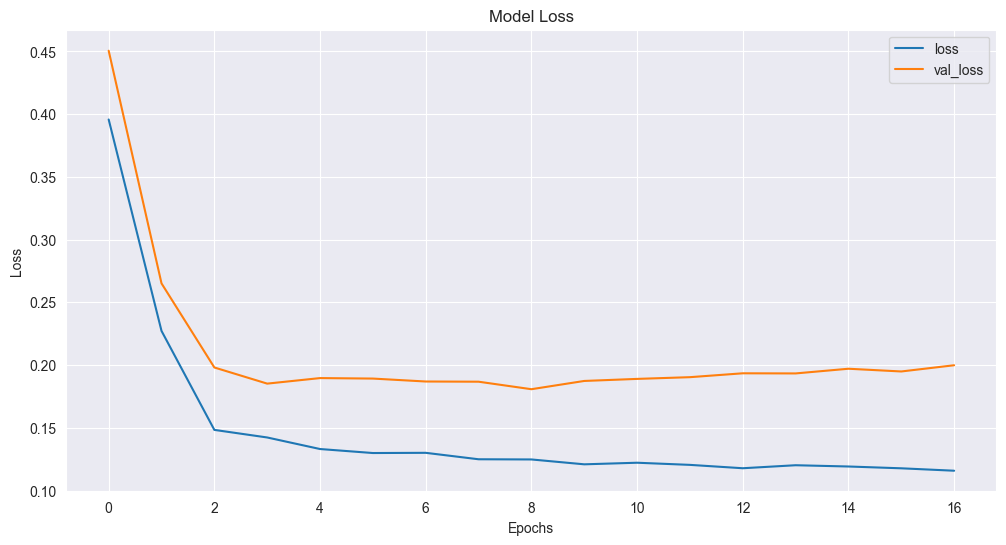

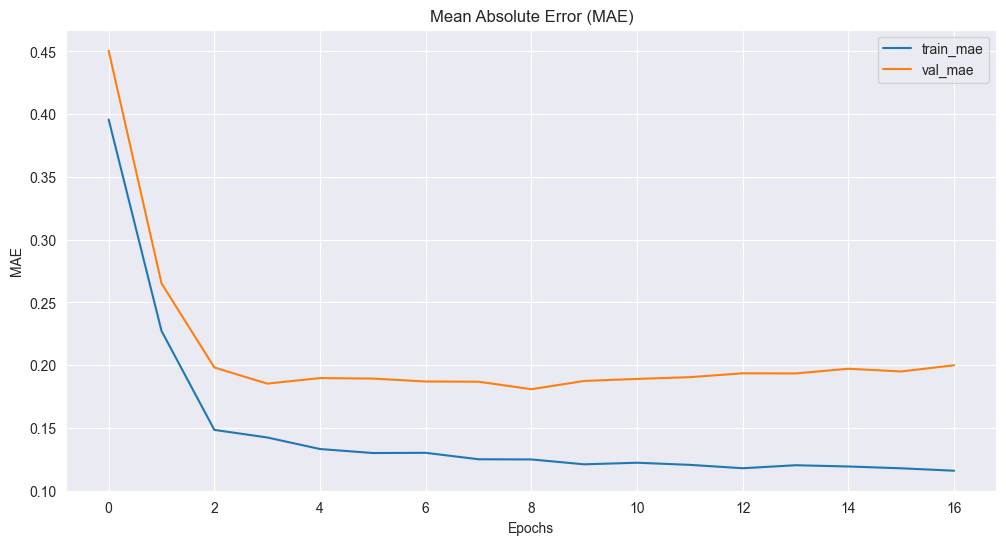

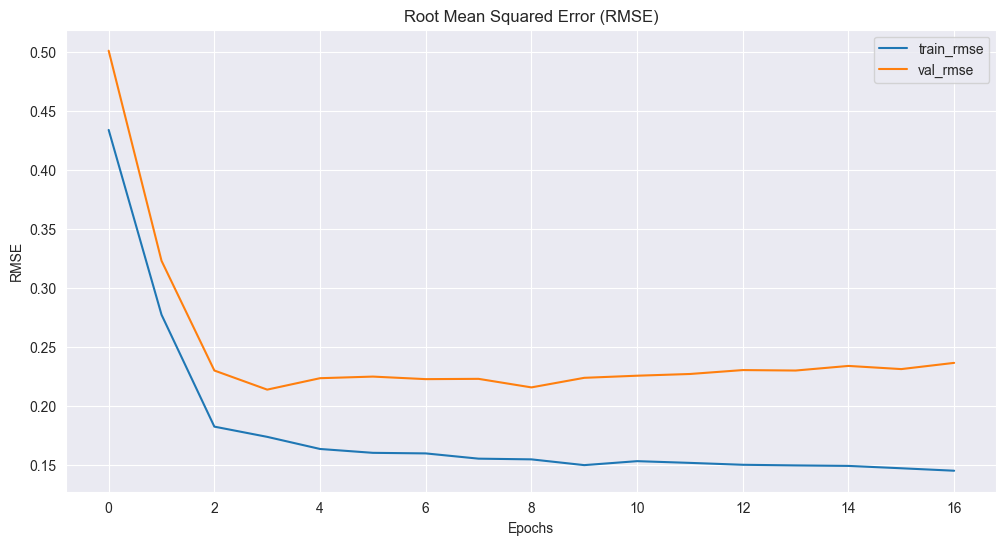

In [795]:
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# design network

# Define the model
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['mae', 'mse', 'mape'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-4)

# Fit the network
history = model.fit(train_X, train_y, epochs=100, batch_size=64, validation_data=(test_X, test_y),
                    verbose=2, shuffle=False,callbacks=[early_stopping, reduce_lr])

# Calculate MAPE manually, handling zero values
def safe_mape(y_true, y_pred, epsilon=1e-10):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / (y_true[mask] + epsilon))) * 100

train_predictions = model.predict(train_X)
test_predictions = model.predict(test_X)

train_mape = safe_mape(train_y, train_predictions.squeeze())
test_mape = safe_mape(test_y, test_predictions.squeeze())


print(f'Train MAPE: {train_mape}')
print(f'Test MAPE: {test_mape}')

# Plot history for loss, MAE, and RMSE as before
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Mean Absolute Error (MAE)')
plt.show()

train_rmse = np.sqrt(history.history['mse'])
val_rmse = np.sqrt(history.history['val_mse'])
plt.figure(figsize=(12, 6))
plt.plot(train_rmse, label='train_rmse')
plt.plot(val_rmse, label='val_rmse')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.title('Root Mean Squared Error (RMSE)')
plt.show()

In [796]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

# Make predictions using the existing model
yhat = model.predict(test_X)

# Reshape test_X for inverse scaling
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X_reshaped), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

# Invert scaling for actual
test_y_reshaped = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y_reshaped, test_X_reshaped), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

# Calculate RMSE, MAE, MAPE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100

print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
RMSE: 1.292
MAE: 1.084
MAPE: 27.377


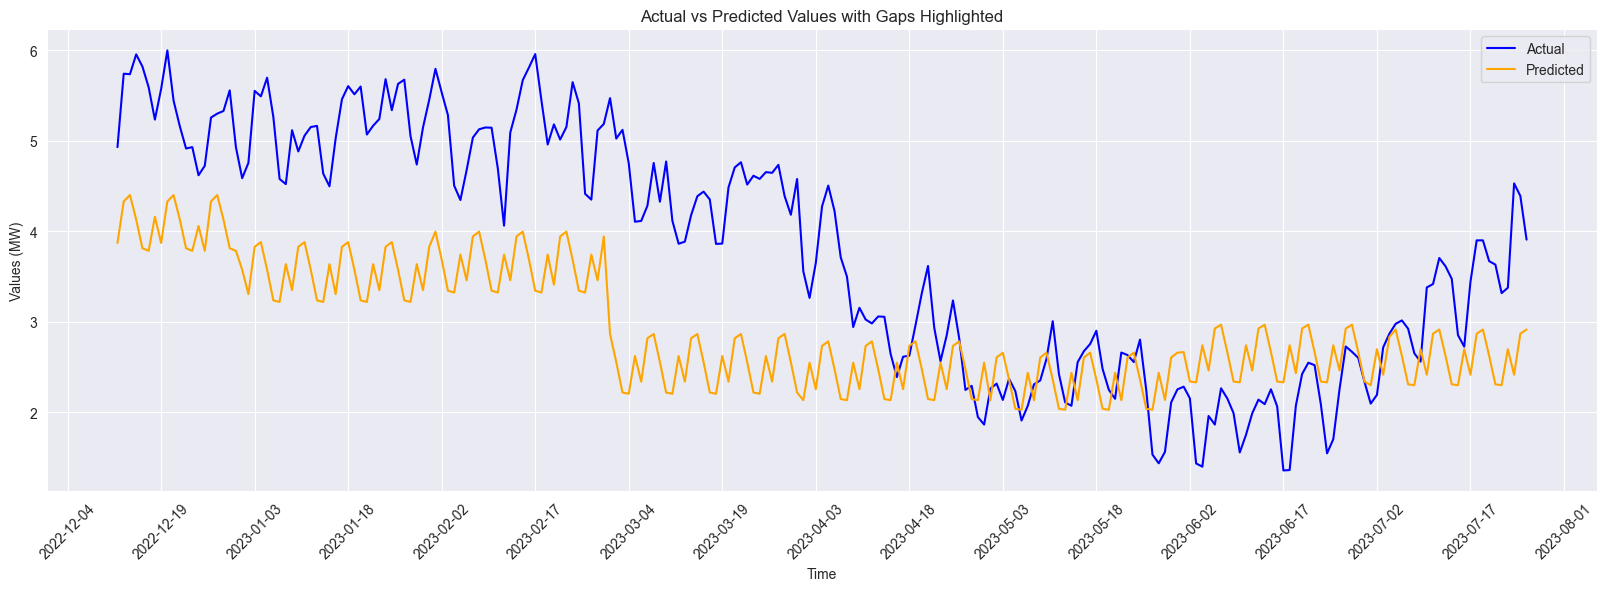

Gaps in data:


In [797]:
# Extract the test data with timestamps
test_df = daily_gross_load.iloc[train_days:, :].copy()
test_df['date'] = daily_gross_load.iloc[train_days:]['date']


# Identify gaps in the data
actual_vs_predicted = pd.DataFrame({
    'date': test_df['date'],
    'actual': inv_y,
    'predicted': inv_yhat
})

# Check for gaps in the timestamps (in days)
actual_vs_predicted['date_diff'] = actual_vs_predicted['date'].diff().dt.days
gaps = actual_vs_predicted[actual_vs_predicted['date_diff'] > 1]

# Plot actual vs predicted values with gaps highlighted
plt.figure(figsize=(20, 6))
plt.plot(actual_vs_predicted['date'], actual_vs_predicted['actual'], label='Actual', color='blue')
plt.plot(actual_vs_predicted['date'], actual_vs_predicted['predicted'], label='Predicted', color='orange')
for gap_start in gaps['date']:
    plt.axvline(x=gap_start, color='red', linestyle='--', alpha=0.5)
plt.title('Actual vs Predicted Values with Gaps Highlighted')
plt.xlabel('Time')
plt.ylabel('Values (MW)')
plt.legend()
plt.grid(True)

# Set date format on x-axis every 15 days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.show()

# Print the gaps and their nearest significant time differences
print("Gaps in data:")
for index, row in gaps.iterrows():
    previous_timestamp = row['date'] - pd.Timedelta(days=row['date_diff'])
    next_timestamp = row['date'] + pd.Timedelta(days=row['date_diff'])

    previous_row = actual_vs_predicted[actual_vs_predicted['date'] == previous_timestamp]
    next_row = actual_vs_predicted[actual_vs_predicted['date'] == next_timestamp]

    gap_start = previous_row['date'].values[0] if not previous_row.empty else 'N/A'
    gap_end = row['date']

    print(f"Gap Start: {pd.to_datetime(gap_start).strftime('%Y-%m-%d') if gap_start != 'N/A' else 'N/A'}")
    print(f"Gap ends at: {gap_end.strftime('%Y-%m-%d')}")
    print(f"Time Difference: {row['date_diff']} days\n")

# out of sample data

In [803]:
daily_gross_load_ofs = daily_gross_load_ofs.sort_values(by='date')
ofs_values = daily_gross_load_ofs.drop(columns='date').values
ofs_dates = daily_gross_load_ofs['date']

# Split into input and output
ofs_X, ofs_y = ofs_values[:, :-1], ofs_values[:, -1]
# Reshape input to be 3D [number of samples, timesteps, number of features]
ofs_X = ofs_X.reshape((ofs_X.shape[0], 1, ofs_X.shape[1]))

In [804]:
# dividing the data into x and y
# x: All columns except the last,  y: The last column
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(904, 1, 11) (904,) (227, 1, 11) (227,)


In [805]:
# concatenate is not defined
from numpy import concatenate
# Make predictions
ofs_predictions = model.predict(ofs_X)

# Reshape OFS data to original 2D shape for inverse transformation
ofs_X_reshaped = ofs_X.reshape((ofs_X.shape[0], ofs_X.shape[2]))

# Invert scaling for forecast
inv_ofs_predictions = concatenate((ofs_predictions, ofs_X_reshaped), axis=1)
inv_ofs_predictions = scaler.inverse_transform(inv_ofs_predictions)
inv_ofs_predictions = inv_ofs_predictions[:, 0]  # First column

# Invert scaling for actual
ofs_y = ofs_y.reshape((len(ofs_y), 1))
inv_ofs_y = concatenate((ofs_y, ofs_X_reshaped), axis=1)
inv_ofs_y = scaler.inverse_transform(inv_ofs_y)
inv_ofs_y = inv_ofs_y[:, 0]  # First column

# Calculate RMSE, MAE, MAPE
ofs_rmse = sqrt(mean_squared_error(inv_ofs_y, inv_ofs_predictions))
ofs_mae = mean_absolute_error(inv_ofs_y, inv_ofs_predictions)
ofs_mape = np.mean(np.abs((inv_ofs_y - inv_ofs_predictions) / inv_ofs_y)) * 100

print('OFS RMSE: %.3f' % ofs_rmse)
print('OFS MAE: %.3f' % ofs_mae)
print('OFS MAPE: %.3f' % ofs_mape)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
OFS RMSE: 0.894
OFS MAE: 0.718
OFS MAPE: 21.651


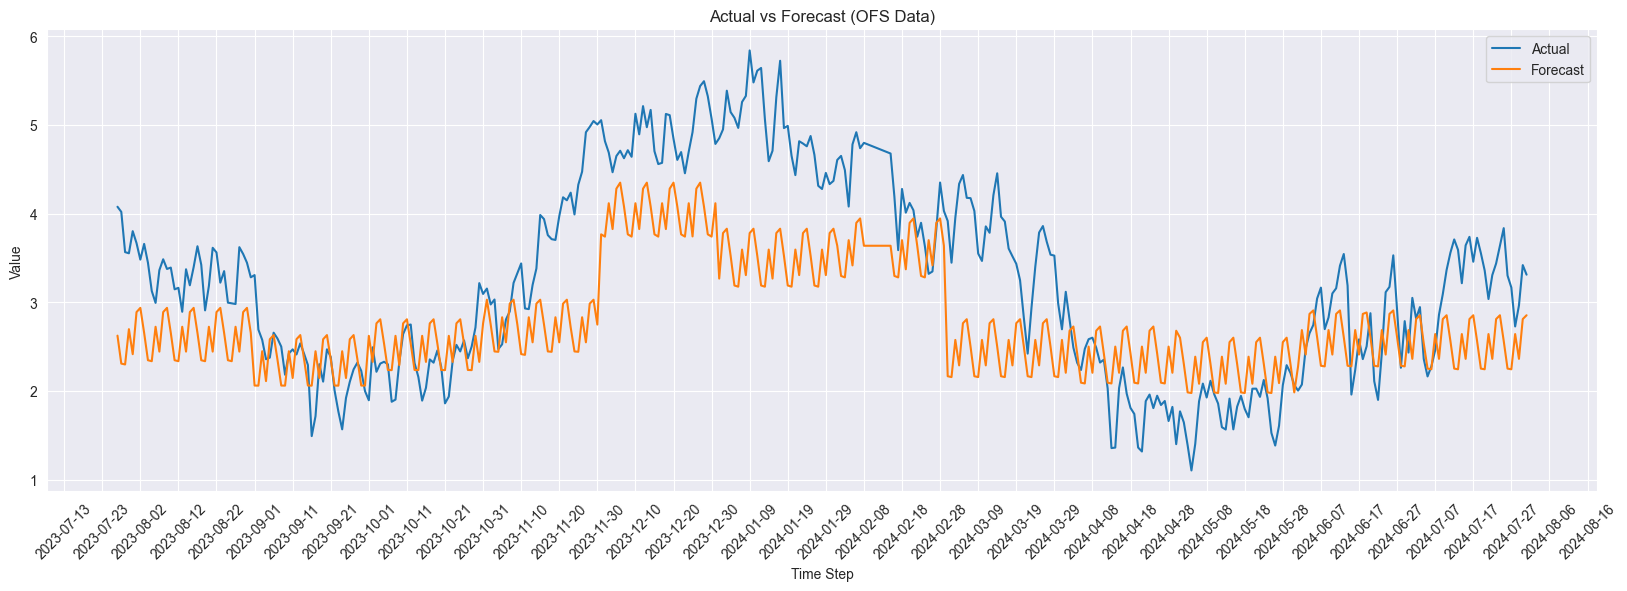

In [809]:
# Plot prediction vs actual
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
plt.plot(ofs_dates, inv_ofs_y, label='Actual')
plt.plot(ofs_dates, inv_ofs_predictions, label='Forecast')
plt.title('Actual vs Forecast (OFS Data)')
plt.ylabel('Value')
plt.xlabel('dates')
plt.legend()
# Set date format on x-axis every 15 days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.show()